## ¿Cuál es un mejor plan?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de los planes genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.



`La tabla users (datos sobre los usuarios):`

- user_id — identificador único del usuario 

- first_name — nombre del usuario 

- last_name — apellido del usuario

- age — edad del usuario (en años)

- reg_date — fecha de suscripción (dd, mm, aa)

- churn_date — la fecha en que el usuario dejó de usar el servicio (si el valor es ausente, la tarifa se estaba usando cuando se recuperaron estos datos)
- city — ciudad de residencia del usuario

- plan — nombre de la tarifa

`La tabla calls (datos sobre las llamadas):`

- id — identificador único de la llamada

- call_date — fecha de la llamada

- duration — duración de la llamada (en minutos)

- user_id — el identificador del usuario que realiza la llamada

`La tabla messages (datos sobre los SMS):`

- id — identificador único del SMS

- message_date — fecha del SMS

- user_id — el identificador del usuario que manda el SMS

`La tabla internet (datos sobre las sesiones web):`

- id — identificador único de la sesión

- mb_used — el volumen de datos gastados durante la sesión (en megabytes)

- session_date — fecha de la sesión web

- user_id — identificador del usuario


`La tabla plans (datos sobre las tarifas):`

- plan_name — nombre de la tarifa

- usd_monthly_fee — pago mensual en dólares estadounidenses

- minutes_included — minutos incluidos al mes

- messages_included — SMS incluidos al mes

- mb_per_month_included — datos incluidos al mes (en megabytes)

- usd_per_minute — precio por minuto tras exceder los límites del paquete (por ejemplo, si el paquete incluye 100 minutos el operador cobrará el minuto 101)

- usd_per_message — precio por SMS tras exceder los límites del paquete

- usd_per_gb — precio por gigabyte de los datos extra tras exceder los límites del paquete (1 GB = 1024 megabytes)

## Inicialización

In [1]:
# Cargar todas las librerías

import pandas as pd
import numpy as np
import seaborn as sns
import math
from scipy import stats
from scipy.stats import ttest_ind
import re
from functools import reduce
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

## Cargar los datos

In [2]:
# Carga los archivos de datos en diferentes DataFrame

try: #anaconda
    calls = pd.read_csv('megaline_calls.csv')
    internet= pd.read_csv('megaline_internet.csv')
    messages= pd.read_csv('megaline_messages.csv')
    plans= pd.read_csv('megaline_plans.csv')
    users= pd.read_csv('megaline_users.csv')
      
    
except: #jupyter
    calls = pd.read_csv('/datasets/megaline_calls.csv') 
    internet= pd.read_csv('/datasets/megaline_internet.csv')
    messages= pd.read_csv('/datasets/megaline_messages.csv')
    plans= pd.read_csv('/datasets/megaline_plans.csv')
    users= pd.read_csv('/datasets/megaline_users.csv')

## Preparar los datos

In [3]:
# Creamos una funcion para visualizar los datos

def data_info(df):
    print('---------------------------------------')
    print('Filas y columnas: \n{}'.format(df.shape))
    print()
    print('Informacion general:')
    print(df.info())
    print()
    print('Primeras cinco columnas: \n{}'.format(df.head()))
    print()
    print('Detalles estadisticos: \n{}'.format(df.describe()))
    print()
    print('Cuantos duplicados hay?\n')
    print('Hay {} datos duplicados.'.format(df.duplicated().sum()))
    print()
    print('Valores ausentes ?')
    print(df.isna().sum(),'\n')
    print('Porcentaje de valores ausentes \n')
    print(df.isna().mean().reset_index())
    print('---------------------------------------')

In [4]:
# funcion para convertir a formato fecha

def convert_to_datetime(df, column_name):
    """
    Esta función convierte una columna de un DataFrame a tipo datetime 
    Returns:
    pandas.DataFrame: El DataFrame con la columna convertida a tipo datetime.
    """
    df[column_name] = pd.to_datetime(df[column_name])
    return df

In [5]:
#Remover user_id de otras tablas
extract_id = np.vectorize(lambda x: re.sub('.*_', '' ,  x))

"""
Esta funcion elimina todo el texto que precede al guión bajo en una cadena de texto.

Específicamente, el patrón de expresión regular '.*_' utilizado en la función re.sub() significa:
    .: Cualquier carácter.
    *: Cero o más ocurrencias del carácter anterior.
    _: El carácter guión bajo.

la expresión regular '.*_' coincide con cualquier carácter que aparezca antes del último guión bajo en una cadena de texto y, por lo tanto, lo elimina de la cadena.

 En este caso, la función lambda se aplica a cada elemento de un arreglo que se pasa como argumento al método extract_id."""

"\nEsta funcion elimina todo el texto que precede al guión bajo en una cadena de texto.\n\nEspecíficamente, el patrón de expresión regular '.*_' utilizado en la función re.sub() significa:\n    .: Cualquier carácter.\n    *: Cero o más ocurrencias del carácter anterior.\n    _: El carácter guión bajo.\n\nla expresión regular '.*_' coincide con cualquier carácter que aparezca antes del último guión bajo en una cadena de texto y, por lo tanto, lo elimina de la cadena.\n\n En este caso, la función lambda se aplica a cada elemento de un arreglo que se pasa como argumento al método extract_id."

In [6]:
def get_date(df):
    columns = df.columns.tolist()
    idx = [columns.index(x) for x in columns if 'date' in x][0]
    
    df[columns[idx]] = pd.to_datetime(df[columns[idx]])
    df['month'] = df[columns[idx]].dt.month_name()
    df['year'] = df[columns[idx]].dt.year

## 01.Planes

In [7]:
# Imprime la información general/resumen sobre el DataFrame de los planes
data_info(plans)

---------------------------------------
Filas y columnas: 
(2, 8)

Informacion general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes
None

Primeras cinco columnas: 
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000  

In [8]:
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


el archivo  plan describe dos planes existentes; el plan surf y ultimate. y en el plan se detalla las siguientes variables:
 
mb_per_month_included : Megabytes del plan
minutes_included: los minutos incluidos       
usd_monthly_pay: el precio       
usd_per_gb: precio por gb           
usd_per_message: precio por mensaje
usd_per_minute: precio por minuto
plan_name: nombre del plan  

no se encuentran datos erroneos en los datos ni duplicados , pero si en el nombre de las columnas. en la proxima seccion se corregirian las columnas 


`Corregir los datos`

se reemplazarán los nombres de la columna

In [9]:
plans.columns = ['messages_included', 'data_volume_per_month', 'minutes_included', 'monthly_fee', 'price_per_gb', 'price_per_message', 'price_per_minute', 'plan']
plans.head()


,messages_included,data_volume_per_month,minutes_included,monthly_fee,price_per_gb,price_per_message,price_per_minute,plan
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


`Enriquecer los datos`

No es necesario agregar más campos o realizar modificaciones. los datos estan correctos

## Usuarios

In [10]:
# Imprime la información general/resumen sobre el DataFrame de los usuarios
data_info(users)

---------------------------------------
Filas y columnas: 
(500, 8)

Informacion general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None

Primeras cinco columnas: 
   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3  

In [11]:
# Imprime una muestra de los datos para los usuarios
users.describe().round(1)

,user_id,age
count,500.0,500.0
mean,1249.5,45.5
std,144.5,17.0
min,1000.0,18.0
25%,1124.8,30.0
50%,1249.5,46.0
75%,1374.2,61.0
max,1499.0,75.0


In [12]:
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


La tabla users se compone de los datos de los usuarios, esta el nombre, apellido, edad, ciudad, plan y churn_date fecha en que el usuario dejó de usar el servicio (si el valor es ausente, la tarifa se estaba usando cuando se recuperaron estos datos)a fecha en que el usuario dejó de usar el servicio. 
lo que se realizará para corregir los datos es lo siguiente:
1. modificar el nombre de las columnas
2. colocar todos los datos en minuscula
3. reemplazar los valores ausentes
4. convertir la variable reg_date a formato fecha


### Corregir datos

In [13]:

# Convertimos todas las columnas a minúsculas utilizando applymap y str.lower()

users = users.applymap(lambda s: s.lower() if type(s) == str else s)

users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,anamaria,bauer,45,"atlanta-sandy springs-roswell, ga msa",2018-12-24,ultimate,NaN
1,1001,mickey,wilkerson,28,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,NaN
2,1002,carlee,hoffman,36,"las vegas-henderson-paradise, nv msa",2018-10-21,surf,NaN
3,1003,reynaldo,jenkins,52,"tulsa, ok msa",2018-01-28,surf,NaN
4,1004,leonila,thompson,40,"seattle-tacoma-bellevue, wa msa",2018-05-23,surf,NaN


In [14]:
# modificar el formato a fecha 

convert_to_datetime(users, 'reg_date')
convert_to_datetime(users, 'churn_date')   


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,anamaria,bauer,45,"atlanta-sandy springs-roswell, ga msa",2018-12-24,ultimate,NaT
1,1001,mickey,wilkerson,28,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,NaT
2,1002,carlee,hoffman,36,"las vegas-henderson-paradise, nv msa",2018-10-21,surf,NaT
3,1003,reynaldo,jenkins,52,"tulsa, ok msa",2018-01-28,surf,NaT
4,1004,leonila,thompson,40,"seattle-tacoma-bellevue, wa msa",2018-05-23,surf,NaT
...,...,...,...,...,...,...,...,...
495,1495,fidel,sharpe,67,"new york-newark-jersey city, ny-nj-pa msa",2018-09-04,surf,NaT
496,1496,ariel,shepherd,49,"new orleans-metairie, la msa",2018-02-20,surf,NaT
497,1497,donte,barrera,49,"los angeles-long beach-anaheim, ca msa",2018-12-10,ultimate,NaT
498,1498,scot,williamson,51,"new york-newark-jersey city, ny-nj-pa msa",2018-02-04,surf,NaT


In [15]:
# detectar los valores ausentes

users.isnull().sum()

user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64

In [16]:
#rellenar los valores ausentes por 0-0-0 para referirse a que la cuenta esta activa
users['churn_date'] = users['churn_date'].fillna(0-0-0)

In [17]:
users.isnull().sum()

user_id       0
first_name    0
last_name     0
age           0
city          0
reg_date      0
plan          0
churn_date    0
dtype: int64

In [18]:
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,anamaria,bauer,45,"atlanta-sandy springs-roswell, ga msa",2018-12-24,ultimate,0
1,1001,mickey,wilkerson,28,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,0
2,1002,carlee,hoffman,36,"las vegas-henderson-paradise, nv msa",2018-10-21,surf,0
3,1003,reynaldo,jenkins,52,"tulsa, ok msa",2018-01-28,surf,0
4,1004,leonila,thompson,40,"seattle-tacoma-bellevue, wa msa",2018-05-23,surf,0


### Enriquecer datos

## Llamadas

In [19]:
# Imprime la información/resumen general sobre el DataFrame de las llamadas
data_info(calls)

---------------------------------------
Filas y columnas: 
(137735, 4)

Informacion general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None

Primeras cinco columnas: 
         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22

Detalles estadisticos: 
             user_id       duration
count  137735.000000  137735.000000
mean     1247.658046       6.745927
std       139.416268       5.839241
min      1000.000000       0.0

In [20]:
# Imprime una muestra de datos para llamadas

calls.tail()

,id,user_id,call_date,duration
137730,1499_199,1499,2018-11-21,8.72
137731,1499_200,1499,2018-10-20,10.89
137732,1499_201,1499,2018-09-21,8.12
137733,1499_202,1499,2018-10-10,0.37
137734,1499_203,1499,2018-12-29,13.86


#### Conclucíón
- No hay valores duplicados ni vacios 
- id column contains 2 ids, the first one is the user id (we already have this column). We can delete the first part and change the data type.
-  hay que modificar el tipo de formato de la tabla call_date
- se puede agregar una categorizacion por duracion de la llamada, y el 0 sera para llamadas perdidas

### Corregir datos

In [21]:
#Modificar el formato de call_date
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d %H:%M:%S')

In [22]:
# Extraer user_id de la columna id 

calls['id'] = extract_id(calls['id'])

### Enriquecer datos

In [23]:
# Separamos la fecha por año y mes 
get_date(calls)

In [24]:
# Agregar una categorizacion de llamadas

def call_category(c):
    if c == 0:
        return 'Missed call'
    else:
        return 'Connected call'

# agregar una nueva columna con la categorizacion

calls['call type'] = calls['duration'].apply(call_category)

In [25]:
calls.head()

,id,user_id,call_date,duration,month,year,call type
0,93,1000,2018-12-27,8.52,December,2018,Connected call
1,145,1000,2018-12-27,13.66,December,2018,Connected call
2,247,1000,2018-12-27,14.48,December,2018,Connected call
3,309,1000,2018-12-28,5.76,December,2018,Connected call
4,380,1000,2018-12-30,4.22,December,2018,Connected call


In [26]:
calls['call type'].value_counts()

Connected call    110901
Missed call        26834
Name: call type, dtype: int64

In [27]:
# Redondear los que tiene una duracion menor a 1 a 1 minuto

calls.loc[calls['duration']<1,'user_id'].value_counts()
calls['duration'] = np.ceil(calls['duration']).astype('int64')

In [28]:
calls.head(8)

,id,user_id,call_date,duration,month,year,call type
0,93,1000,2018-12-27,9,December,2018,Connected call
1,145,1000,2018-12-27,14,December,2018,Connected call
2,247,1000,2018-12-27,15,December,2018,Connected call
3,309,1000,2018-12-28,6,December,2018,Connected call
4,380,1000,2018-12-30,5,December,2018,Connected call
5,388,1000,2018-12-31,3,December,2018,Connected call
6,510,1000,2018-12-27,6,December,2018,Connected call
7,521,1000,2018-12-28,15,December,2018,Connected call


## Mensajes

In [29]:
# Imprime la información/resumen general sobre el DataFrame de los mensajes
data_info(messages)

---------------------------------------
Filas y columnas: 
(76051, 3)

Informacion general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None

Primeras cinco columnas: 
         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26

Detalles estadisticos: 
            user_id
count  76051.000000
mean    1245.972768
std      139.843635
min     1000.000000
25%     1123.000000
50%     1251.000000
75%     1362.000000
max     1497.000000

Cuantos duplicados hay?

Hay 0 datos duplicados.

Valores ausentes ?
id              0
user_id    

In [30]:
# Imprime una muestra de datos para los mensajes
messages.head()


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26



No hay datos duplicados ni vacios. para ordenar y limpiar los datos de la tabla mensajes, se realizará lo siguiente;

1. modificar el formato de fecha de la columna message_data
2. separar el campo id

### Corregir datos

In [31]:
#Modificar el formato de call_date
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d %H:%M:%S')

In [32]:
# Extraer user_id de la columna id 

messages['id'] = extract_id(messages['id'])

In [33]:
get_date(messages)

In [34]:
messages.head(1)

,id,user_id,message_date,month,year
0,125,1000,2018-12-27,December,2018


## Internet

In [35]:
# Imprime la información/resumen general sobre el DataFrame de los mensajes
data_info(internet)

---------------------------------------
Filas y columnas: 
(104825, 4)

Informacion general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
None

Primeras cinco columnas: 
         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22

Detalles estadisticos: 
             user_id        mb_used
count  104825.000000  104825.000000
mean     1242.496361     366.713701
std       142.053913     277.170542
min      100

In [36]:
# Imprime una muestra de datos para el tráfico de internet
internet.head(1)

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86


No hay datos nulos ni duplicados. 

Se debe corregir los siguiente;
- separar el id 
- modificar la fecha de session_date
- agregar una columna conviertiendo mb por gb

### Corregir datos

In [37]:
#Modificar el formato de la columna de fecha
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d %H:%M:%S')

In [38]:
# Extraer el id
internet['id'] = extract_id(internet['id'])

### Enriquecer datos

In [39]:
# Agregar campo mes
get_date(internet)

convertir los mg por gb

In [40]:
internet.head(1)

,id,user_id,session_date,mb_used,month,year
0,13,1000,2018-12-29,89.86,December,2018


In [41]:
# agregamos una nueva columna tranformado los datos a GB
internet['gb_used'] = internet['mb_used'] / 1024

In [42]:
internet.head()

,id,user_id,session_date,mb_used,month,year,gb_used
0,13,1000,2018-12-29,89.86,December,2018,0.087754
1,204,1000,2018-12-31,0.00,December,2018,0.000000
2,379,1000,2018-12-28,660.40,December,2018,0.644922
3,413,1000,2018-12-26,270.99,December,2018,0.264639
4,442,1000,2018-12-27,880.22,December,2018,0.859590


In [43]:
data_used = internet.groupby(['user_id','year','month'])[['gb_used']].agg(['sum']).reset_index()
data_used


,user_id,year,month,gb_used
,,,,sum
0,1000,2018,December,1.856904
1,1001,2018,August,6.756982
2,1001,2018,December,18.915215
3,1001,2018,November,18.070605
4,1001,2018,October,21.807119
...,...,...,...,...
2272,1498,2018,September,22.292266
2273,1499,2018,December,21.542197
2274,1499,2018,November,16.419756


## Estudiar las condiciones del plan

Las condiciones del plan son los siguientes 

`Surf`
 
 
Monthly charge:$20

500 monthly minutes, 50 texts, and 15 GB of data

After exceeding the package limits:

- 1 minute: 3 cents
- 1 text message: 3 cents
- 1 GB of data: $10

`Ultimate`

Monthly charge: $70

3000 monthly minutes, 1000 text messages, and 30 GB of data

After exceeding the package limits:

- 1 minute: 1 cent
- text message: 1 cent
- GB of data: $7

## Agregar datos por usuario

El objetivo de lo siguiente es agrupar los datos para tener solo un dato de cada usuario y reducir los datos, de esta manera reducirmos las tablas

In [44]:
# Calcula el número de llamadas hechas por cada usuario por mes. Guarda el resultado.<
calls_per_month = calls.groupby(['user_id', 'month']).agg({'id': 'count'}).rename(columns={'id': 'calls made'}).reset_index()
calls_per_month

,user_id,month,calls made
0,1000,December,16
1,1001,August,27
2,1001,December,56
3,1001,November,64
4,1001,October,65
...,...,...,...
2253,1498,September,45
2254,1499,December,65
2255,1499,November,45
2256,1499,October,53


In [45]:
# Calcula la cantidad de minutos que usó cada usuario por mes. Guarda el resultado.
mins_per_month = calls.groupby(['user_id', 'month']).agg({'duration': 'sum'}).rename(columns={'duration': 'minutes spent'}).reset_index()
mins_per_month

,user_id,month,minutes spent
0,1000,December,124
1,1001,August,182
2,1001,December,412
3,1001,November,426
4,1001,October,393
...,...,...,...
2253,1498,September,363
2254,1499,December,496
2255,1499,November,308
2256,1499,October,385


In [46]:
# Calcula el número de mensajes enviados por cada usuario por mes. Guarda el resultado.
messages_per_month = messages.groupby(['user_id', 'month']).agg({'id': 'count'}).rename(columns={'id': 'messages sent'}).reset_index()
messages_per_month

,user_id,month,messages sent
0,1000,December,11
1,1001,August,30
2,1001,December,44
3,1001,November,36
4,1001,October,53
...,...,...,...
1801,1496,December,11
1802,1496,November,13
1803,1496,October,18
1804,1496,September,21


In [47]:
#Agrupando el trafico de usuario por mes
internet_per_month = internet.groupby(['user_id', 'month']).agg({'gb_used': 'sum'}).reset_index()
internet_per_month['gb_used'] = internet_per_month['gb_used'].apply(lambda x: math.ceil(x))
internet_per_month

,user_id,month,gb_used
0,1000,December,2
1,1001,August,7
2,1001,December,19
3,1001,November,19
4,1001,October,22
...,...,...,...
2272,1498,September,23
2273,1499,December,22
2274,1499,November,17
2275,1499,October,20


In [48]:
# Combina los datos para las llamadas, minutos, mensajes e internet con base en el user_id y el mes
data_frames = [calls_per_month, mins_per_month, messages_per_month, internet_per_month]
df = reduce(lambda left,right: pd.merge(left,right,on=['user_id','month'], how='outer'), data_frames)

df=df.reset_index(drop=True)
df.head(5)

,user_id,month,calls made,minutes spent,messages sent,gb_used
0,1000,December,16.0,124.0,11.0,2.0
1,1001,August,27.0,182.0,30.0,7.0
2,1001,December,56.0,412.0,44.0,19.0
3,1001,November,64.0,426.0,36.0,19.0
4,1001,October,65.0,393.0,53.0,22.0


In [49]:
# Añade la información del plan
plans

,messages_included,data_volume_per_month,minutes_included,monthly_fee,price_per_gb,price_per_message,price_per_minute,plan
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [50]:
# Añadimos el plan en el df

df = pd.merge(df, users[['user_id', 'plan']], on ='user_id')
df.head()

,user_id,month,calls made,minutes spent,messages sent,gb_used,plan
0,1000,December,16.0,124.0,11.0,2.0,ultimate
1,1001,August,27.0,182.0,30.0,7.0,surf
2,1001,December,56.0,412.0,44.0,19.0,surf
3,1001,November,64.0,426.0,36.0,19.0,surf
4,1001,October,65.0,393.0,53.0,22.0,surf


In [51]:
# Calcula el ingreso mensual para cada usuario

#Definimos los puntos 


def monthly_pay(row):
    
    plan = row['plan']
    call_duration = row['minutes spent']   
    text_duratiom = row['messages sent']
    data_use = row['gb_used']
    call_revenue = 0
    text_revenue = 0
    data_revenue = 0
    
#Aplicacmos las condiciones de cada plan 
    if plan=='surf':
        fix_cost = 20
        call_limit = 500
        minut_fee = 0.03
        text_limit = 50
        text_fee = 0.03
        data_limit = 15
        data_fee = 10

           
    else:
        
        fix_cost = 70
        call_limit = 3000
        minut_fee = 0.01
        text_limit = 1000
        text_fee = 0.01
        data_limit = 30
        data_fee = 7

 # calculamos el excedente  llamadas       
    if call_duration > call_limit:
        call_revenue = (call_duration-call_limit) * minut_fee

# calculamos el excedente de mensajes    

    if text_duratiom > text_limit:
        text_revenue = (text_duratiom-text_limit) * text_fee
        
#   calculamos el excedente de datos       

    if data_use > data_limit:
        data_revenue = (data_use-data_limit) * data_fee
        
# sumamos todos los ingresos para saber el ingreso total mensual de usuario 
    
    revenue = fix_cost + call_revenue + text_revenue + data_revenue 
    return revenue

#Agregamos la columna 

df['revenue_pm'] = df.apply(monthly_pay, axis=1)


In [52]:
#Agregamos la columna 
df['revenue_pm'] = df.apply(monthly_pay, axis=1).round(1)
df.head(5)

,user_id,month,calls made,minutes spent,messages sent,gb_used,plan,revenue_pm
0,1000,December,16.0,124.0,11.0,2.0,ultimate,70.0
1,1001,August,27.0,182.0,30.0,7.0,surf,20.0
2,1001,December,56.0,412.0,44.0,19.0,surf,60.0
3,1001,November,64.0,426.0,36.0,19.0,surf,60.0
4,1001,October,65.0,393.0,53.0,22.0,surf,90.1


In [53]:
df['revenue_pm'].mean()

64.351417357174

## Estudia el comportamiento del usuario

### Llamadas

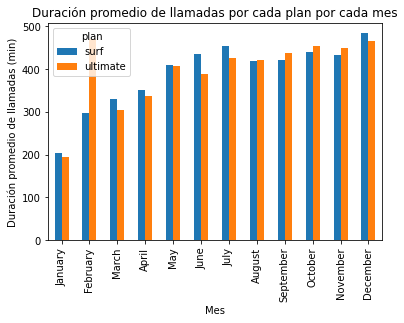

In [54]:
# Compara la duración promedio de llamadas por cada plan por cada mes. Dibuja una gráfica de barras para visualizarlo.

df['month'] = pd.Categorical(df['month'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)

# Calcular la duración promedio de las llamadas para cada plan por cada mes
call_duration = df.groupby(['month', 'plan'])['minutes spent'].mean()

# Dibujar una gráfica de barras para visualizar los resultados
call_duration.unstack().plot(kind='bar')
plt.xlabel('Mes')
plt.ylabel('Duración promedio de llamadas (min)')
plt.title('Duración promedio de llamadas por cada plan por cada mes')
plt.show()

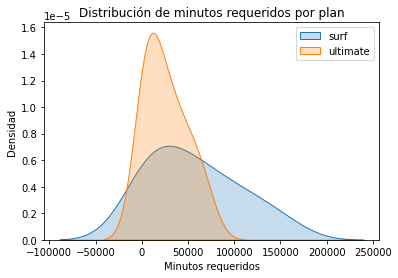

In [55]:
# Compara el número de minutos que los usuarios de cada plan requieren cada mes. Traza un histograma.

# Agregamos los minutos gastados por mes y plan
df_minutes = df.groupby(['plan', 'month'])['minutes spent'].sum().reset_index()

# Filtramos los datos para el plan "surf" y el plan "ultimate"
df_surf = df_minutes[df_minutes['plan'] == 'surf']
df_ultimate = df_minutes[df_minutes['plan'] == 'ultimate']

# Creamos un histograma de densidad  para visualizar la distribución de los minutos gastados
sns.kdeplot(df_surf['minutes spent'], shade=True, label='surf')
sns.kdeplot(df_ultimate['minutes spent'], shade=True, label='ultimate')
plt.xlabel('Minutos requeridos')
plt.ylabel('Densidad')
plt.title('Distribución de minutos requeridos por plan')
plt.legend()
plt.show()

In [56]:
# Calcula la media y la varianza de la duración mensual de llamadas.
means = df.groupby('plan')['minutes spent'].mean()
variances = df.groupby('plan')['minutes spent'].var()

# Imprime los resultados
print('Media de la duración de la llamada por plan:')
print(means)
print('\nVarianza de la duración de la llamada por plan:')
print(variances)

Media de la duración de la llamada por plan:
plan
surf        436.519741
ultimate    434.676017
Name: minutes spent, dtype: float64

Varianza de la duración de la llamada por plan:
plan
surf        52571.063243
ultimate    56573.632247
Name: minutes spent, dtype: float64


<AxesSubplot:xlabel='month', ylabel='minutes spent'>

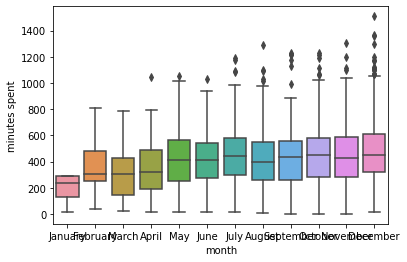

In [57]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas.
sns.boxplot(x='month', y='minutes spent', data=df)

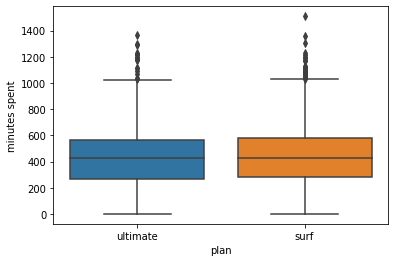

In [58]:
sns.boxplot(x='plan', y='minutes spent', data=df)
plt.show()

Al observar el diagrama de caja que muestra la distribución de la duración mensual de llamadas por plan, podemos concluir lo siguiente:

    En general, los usuarios del plan Ultimate tienden a hacer llamadas más largas que los usuarios del plan Surf. La mediana de la duración mensual de llamadas para el plan Ultimate es mayor que la del plan Surf, y el tercer cuartil es mucho más alto para el plan Ultimate que para el plan Surf. Además, el plan Ultimate tiene valores atípicos (representados por los puntos fuera de los bigotes) que indican que algunos usuarios hacen llamadas muy largas.

    En ambos planes, la duración mensual de las llamadas varía considerablemente entre los diferentes meses. Esto se observa por la variabilidad en la altura de los diagramas de caja y por la presencia de valores atípicos en algunos meses.

    La distribución de la duración mensual de las llamadas parece ser más simétrica para el plan Surf que para el plan Ultimate. Esto se observa por la posición de la mediana y la forma de los bigotes.

En conclusión, podemos decir que los usuarios de diferentes planes muestran comportamientos distintos para sus llamadas. Los usuarios del plan Ultimate tienden a hacer llamadas más largas que los usuarios del plan Surf, pero la duración mensual de las llamadas varía considerablemente entre los diferentes meses en ambos planes. Además, la distribución de la duración mensual de las llamadas parece ser más simétrica para el plan Surf que para el plan Ultimate.

podemos decir que los usuarios de diferentes planes muestran comportamientos distintos para sus llamadas. Los usuarios del plan Ultimate tienden a hacer llamadas más largas que los usuarios del plan Surf, pero la duración mensual de las llamadas varía considerablemente entre los diferentes meses en ambos planes. Además, la distribución de la duración mensual de las llamadas parece ser más simétrica para el plan Surf que para el plan Ultimate.

### Mensajes

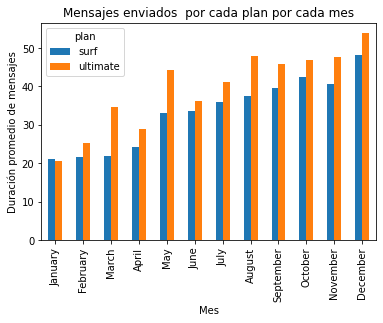

In [59]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan.

df['month'] = pd.Categorical(df['month'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)

# Calcular la duración promedio de mensajes enviados  para cada plan por cada mes
messages_sent = df.groupby(['month', 'plan'])['messages sent'].mean()

# Dibujar una gráfica de barras para visualizar los resultados
messages_sent.unstack().plot(kind='bar')
plt.xlabel('Mes')
plt.ylabel('Duración promedio de mensajes')
plt.title('Mensajes enviados  por cada plan por cada mes')
plt.show()

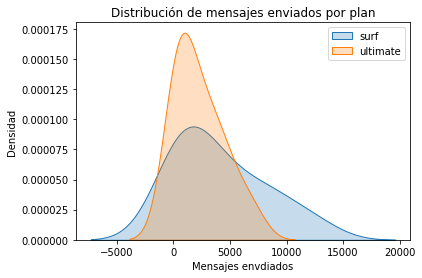

In [60]:
# Compara la cantidad de tráfico de internet consumido por usuarios por plan


# Agregamos los minutos gastados por mes y plan
df_messages = df.groupby(['plan', 'month'])['messages sent'].sum().reset_index()

# Agregamos los minutos gastados por mes y plan
df_surf_m = df_messages[df_messages['plan'] == 'surf']
df_ultimate_m = df_messages[df_messages['plan'] == 'ultimate']

#Creamos un histograma de densidad  para visualizar la distribución de los minutos gastados
sns.kdeplot(df_surf_m['messages sent'], shade=True, label='surf')
sns.kdeplot(df_ultimate_m['messages sent'], shade=True, label='ultimate')
plt.xlabel('Mensajes envdiados')
plt.ylabel('Densidad')
plt.title('Distribución de mensajes enviados por plan')
plt.legend()
plt.show()



In [61]:
means = df.groupby('plan')['messages sent'].mean()
variances = df.groupby('plan')['messages sent'].var()

# Imprime los resultados
print('Media mensajes enviados por mes :')
print(means)
print('\nVarianza de mensajes enviados por mes:')
print(variances)

Media mensajes enviados por mes :
plan
surf        40.109656
ultimate    46.296233
Name: messages sent, dtype: float64

Varianza de mensajes enviados por mes:
plan
surf        1091.344231
ultimate    1085.183108
Name: messages sent, dtype: float64


<AxesSubplot:xlabel='month', ylabel='messages sent'>

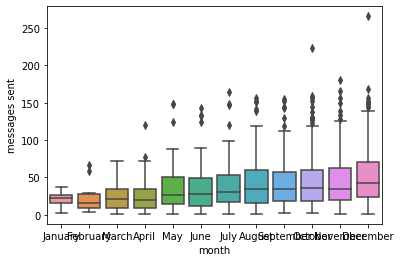

In [62]:
sns.boxplot(x='month', y='messages sent', data=df)

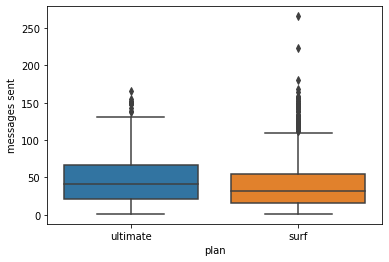

In [63]:
sns.boxplot(x='plan', y='messages sent', data=df)
plt.show()

Podemos observar que los usuarios de ambos planes tienden a enviar más mensajes a medida que pasa el tiempo, ya que la mediana de los dos planes aumenta en los meses posteriores. También podemos ver que los usuarios del plan "ultimate" tienden a enviar más mensajes en promedio que los usuarios del plan "surf" en la mayoría de los meses.

En general, podemos concluir que el comportamiento de los usuarios en cuanto al número de mensajes enviados es diferente entre los dos planes, con los usuarios del plan "ultimate" enviando más mensajes en promedio que los usuarios del plan "surf".

### Internet

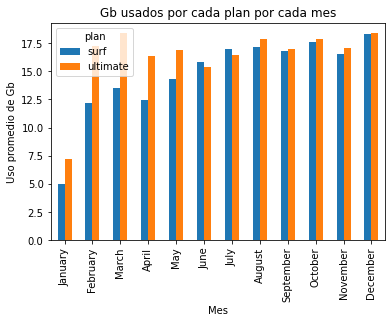

In [64]:
internet_use = df.groupby(['month', 'plan'])['gb_used'].mean()

# Dibujar una gráfica de barras para visualizar los resultados
internet_use.unstack().plot(kind='bar')
plt.xlabel('Mes')
plt.ylabel('Uso promedio de Gb')
plt.title('Gb usados por cada plan por cada mes')
plt.show()

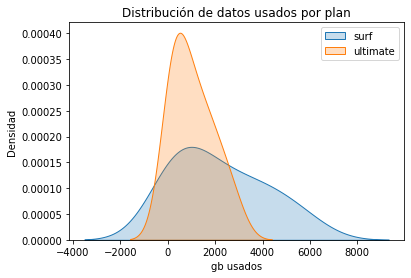

In [65]:
x= ['gb_used']
# Agregamos los minutos gastados por mes y plan
df_gb = df.groupby(['plan', 'month'])['gb_used'].sum().reset_index()

# Agregamos los minutos gastados por mes y plan
df_surf_gb = df_gb[df_gb['plan'] == 'surf']
df_ultimate_gb = df_gb[df_gb['plan'] == 'ultimate']

#Creamos un histograma de densidad  para visualizar la distribución de los datos gastados
sns.kdeplot(df_surf_gb['gb_used'], shade=True, label='surf')
sns.kdeplot(df_ultimate_gb['gb_used'], shade=True, label='ultimate')
plt.xlabel('gb usados')
plt.ylabel('Densidad')
plt.title('Distribución de datos usados por plan')
plt.legend()
plt.show()


In [66]:
means = df.groupby('plan')['gb_used'].mean()
variances = df.groupby('plan')['gb_used'].var()

# Imprime los resultados
print('El promedio trafico de internet usado por mes :')
print(means)
print('\nVarianza trafico de internet usado por mes:')
print(variances)

El promedio trafico de internet usado por mes :
plan
surf        16.831194
ultimate    17.331015
Name: gb_used, dtype: float64

Varianza trafico de internet usado por mes:
plan
surf        59.473734
ultimate    58.494733
Name: gb_used, dtype: float64


<AxesSubplot:xlabel='month', ylabel='gb_used'>

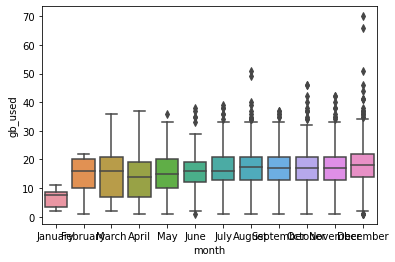

In [67]:
sns.boxplot(x='month', y='gb_used', data=df)

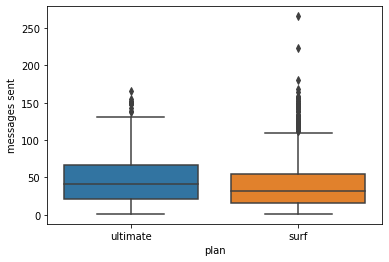

In [68]:
sns.boxplot(x='plan', y='messages sent', data=df)
plt.show()

El diagrama de caja del uso de datos mensual por plan muestra que, en promedio, los usuarios del plan "surf" utilizan menos datos que los usuarios del plan "ultimate". Además, la distribución del uso de datos por mes varía entre los dos planes, con más variabilidad en el plan "ultimate". También podemos observar que el uso de datos tiende a aumentar con el tiempo para ambos planes. En general, el diagrama de caja sugiere que los usuarios de los dos planes tienen comportamientos diferentes en cuanto al uso de datos.

## Ingreso

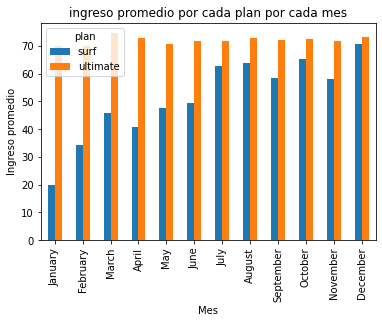

In [69]:
income_plan = df.groupby(['month', 'plan'])['revenue_pm'].mean()

# Dibujar una gráfica de barras para visualizar los resultados
income_plan.unstack().plot(kind='bar')
plt.xlabel('Mes')
plt.ylabel('Ingreso promedio')
plt.title('ingreso promedio por cada plan por cada mes')
plt.show()

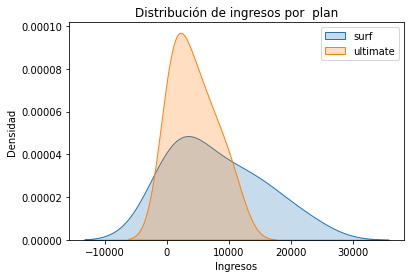

In [70]:
# Agregamos los minutos gastados por mes y plan
df_revenue = df.groupby(['plan', 'month'])['revenue_pm'].sum().reset_index()

# Agregamos los minutos gastados por mes y plan
df_surf_r = df_revenue[df_revenue['plan'] == 'surf']
df_ultimate_r = df_revenue[df_revenue['plan'] == 'ultimate']

#Creamos un histograma de densidad  para visualizar la distribución de los minutos gastados
sns.kdeplot(df_surf_r['revenue_pm'], shade=True, label='surf')
sns.kdeplot(df_ultimate_r['revenue_pm'], shade=True, label='ultimate')
plt.xlabel('Ingresos')
plt.ylabel('Densidad')
plt.title('Distribución de ingresos por  plan')
plt.legend()
plt.show()




In [71]:
means = df.groupby('plan')['revenue_pm'].mean()
variances = df.groupby('plan')['revenue_pm'].var()

# Imprime los resultados
print('El promedio del ingreso por mes :')
print(means)
print('\nVarianza del ingeso por mes:')
print(variances)

El promedio del ingreso por mes :
plan
surf        60.706802
ultimate    72.313889
Name: revenue_pm, dtype: float64

Varianza del ingeso por mes:
plan
surf        3067.884960
ultimate     129.848486
Name: revenue_pm, dtype: float64


<AxesSubplot:xlabel='month', ylabel='revenue_pm'>

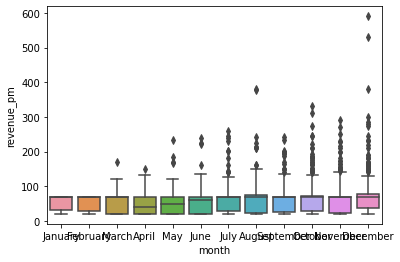

In [72]:
sns.boxplot(x='month', y='revenue_pm', data=df)

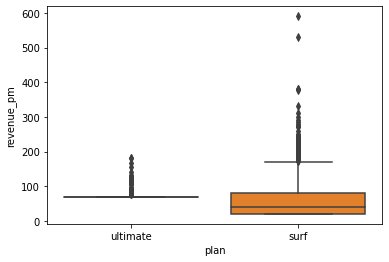

In [73]:
sns.boxplot(x='plan', y='revenue_pm', data=df)
plt.show()

In [74]:
revenue_stats = df.groupby('plan')['revenue_pm'].agg(['mean', 'std'])
print(revenue_stats)

               mean        std
plan                          
surf      60.706802  55.388491
ultimate  72.313889  11.395108


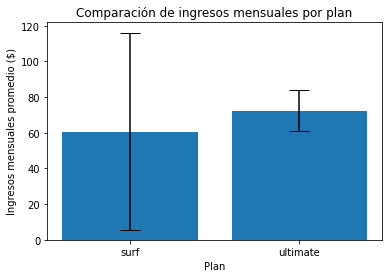

In [75]:

# Creamos un gráfico de barras con las medias y las desviaciones estándar
fig, ax = plt.subplots()
ax.bar(x=revenue_stats.index, height=revenue_stats['mean'], yerr=revenue_stats['std'], capsize=10)

# Añadimos etiquetas y título al gráfico
ax.set_xlabel('Plan')
ax.set_ylabel('Ingresos mensuales promedio ($)')
ax.set_title('Comparación de ingresos mensuales por plan')

# Mostramos el gráfico
plt.show()

El resultado muestra que los usuarios del plan "ultimate" generan, en promedio, más ingresos mensuales que los usuarios del plan "surf". Esta diferencia puede deberse a varias razones, como el precio de los planes o las características de los servicios ofrecidos.

Además, podemos observar que la desviación estándar es mayor para el plan "surf" que para el plan "ultimate". Esto sugiere que los ingresos mensuales de los usuarios del plan "surf" son más variables que los ingresos mensuales de los usuarios del plan "ultimate". Esta variabilidad puede deberse a diferencias en el uso de los servicios o en la cantidad de usuarios del plan "surf" que se ajustan a su límite de datos, lo que puede afectar su ingreso mensual.

## Probar las hipótesis estadísticas.

    Hipótesis nula (H0): El ingreso promedio de los usuarios de los planes Ultimate y Surf es igual.
    Hipótesis alternativa (H1): El ingreso promedio de los usuarios de los planes Ultimate y Surf es diferente.
    Prueba estadística: Prueba t de dos muestras 
    Valor alfa (nivel de significancia): 0.05.

el objetivo de la prueba es determinar si hay suficiente evidencia estadística para rechazar la hipótesis nula y concluir que los ingresos promedio de los usuarios de los planes Ultimate y Surf son diferentes, con un nivel de significancia del 5%. Si el valor p obtenido es menor que el valor alfa, se rechaza la hipótesis nula y se concluye que hay suficiente evidencia para decir que los ingresos promedio son diferentes. Si el valor p es mayor que el valor alfa, no se rechaza la hipótesis nula y se concluye que no hay suficiente evidencia para decir que los ingresos promedio son diferentes..

In [76]:


# separar los ingresos por plan
ultimate = df[df.plan == 'ultimate']['revenue_pm']
surf = df[df.plan == 'surf']['revenue_pm']

# realizar el test de hipótesis
t_statistic, p_value = stats.ttest_ind(ultimate, surf, equal_var=False)

# imprimir los resultados
print('Test estadístico t: ', t_statistic)
print('Valor p: ', p_value)

# comparar el valor p con el nivel de significancia
alpha = 0.05
if p_value < alpha:
    print('Se rechaza la hipótesis nula')
else:
    print('No se rechaza la hipótesis nula')

Test estadístico t:  7.9517657783402615
Valor p:  3.1785494515113984e-15
Se rechaza la hipótesis nula


Se concluye que los planes Ultimate y Surf tienen diferete ingreso

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Buen trabajo en esta sección.
</div>

`Prueba 2: Ingreso promedio de los usurarios en regiones` 

establecer las hipótesis nula y alternativa
- H0: El ingreso promedio de los usuarios en la región NY-NJ es igual al ingreso promedio de los usuarios en otras regiones.
- H1: El ingreso promedio de los usuarios en la región NY-NJ es diferente al ingreso promedio de los usuarios en otras regiones.
- prueba estadística: Prueba t de dos muestras (two-sample t-test).
- valor alfa: 0.05

In [77]:
users

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,anamaria,bauer,45,"atlanta-sandy springs-roswell, ga msa",2018-12-24,ultimate,0
1,1001,mickey,wilkerson,28,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,0
2,1002,carlee,hoffman,36,"las vegas-henderson-paradise, nv msa",2018-10-21,surf,0
3,1003,reynaldo,jenkins,52,"tulsa, ok msa",2018-01-28,surf,0
4,1004,leonila,thompson,40,"seattle-tacoma-bellevue, wa msa",2018-05-23,surf,0
...,...,...,...,...,...,...,...,...
495,1495,fidel,sharpe,67,"new york-newark-jersey city, ny-nj-pa msa",2018-09-04,surf,0
496,1496,ariel,shepherd,49,"new orleans-metairie, la msa",2018-02-20,surf,0
497,1497,donte,barrera,49,"los angeles-long beach-anaheim, ca msa",2018-12-10,ultimate,0
498,1498,scot,williamson,51,"new york-newark-jersey city, ny-nj-pa msa",2018-02-04,surf,0


In [78]:
# Separamos la region  en la tabla users
users['region'] = users['city'].str.split('-').str[0]

#Aggregamos la region al df

df = pd.merge(df, users[['user_id', 'region']], on ='user_id')
df.head()

,user_id,month,calls made,minutes spent,messages sent,gb_used,plan,revenue_pm,region
0,1000,December,16.0,124.0,11.0,2.0,ultimate,70.0,atlanta
1,1001,August,27.0,182.0,30.0,7.0,surf,20.0,seattle
2,1001,December,56.0,412.0,44.0,19.0,surf,60.0,seattle
3,1001,November,64.0,426.0,36.0,19.0,surf,60.0,seattle
4,1001,October,65.0,393.0,53.0,22.0,surf,90.1,seattle


In [79]:
df['region'].unique()

array(['atlanta', 'seattle', 'las vegas', 'tulsa, ok msa', 'dallas',
       'san francisco', 'grand rapids', 'orlando', 'san jose',
       'cleveland', 'chicago', 'knoxville, tn msa', 'new york',
       'pittsburgh, pa msa', 'fresno, ca msa', 'washington',
       'indianapolis', 'jacksonville, fl msa', 'los angeles', 'omaha',
       'houston', 'philadelphia', 'tampa', 'birmingham',
       'oklahoma city, ok msa', 'charlotte', 'denver', 'nashville',
       'columbus, oh msa', 'albuquerque, nm msa', 'boston', 'miami',
       'san diego', 'phoenix', 'portland', 'cincinnati, oh',
       'columbia, sc msa', 'san antonio', 'buffalo', 'memphis, tn',
       'riverside', 'louisville/jefferson county, ky', 'albany',
       'providence', 'urban honolulu, hi msa', 'el paso, tx msa',
       'new haven', 'north port', 'new orleans', 'bridgeport',
       'virginia beach', 'baltimore', 'milwaukee', 'oxnard',
       'sacramento–roseville–folsom, ca msa', 'austin',
       'richmond, va msa', 'st. louis,

In [80]:

#crearemos un nuevo DataFrame con los usuarios de la región NY-NJ y los de otras regiones por separado.

df_nynj = df[df['region'] == 'new york']
df_other = df[df['region'] != 'new york'] 

#alcularemos las medias de ingresos promedio para cada grupo. 
mean_nynj = df_nynj['revenue_pm'].mean()
mean_other = df_other['revenue_pm'].mean()

print('Promedio de ingreso de NY: ', mean_nynj)
print('Promedio de ingreo de otras ciudades ', mean_other)
# establecer las hipótesis nula y alternativa

t, p = ttest_ind(df_nynj['revenue_pm'], df_other['revenue_pm'])

if p < 0.05:
    print("Rechazamos H0. Hay una diferencia significativa entre los ingresos promedio de los usuarios en la región NY-NJ y los de otras regiones.")
else:
    print("No podemos rechazar H0. No hay una diferencia significativa entre los ingresos promedio de los usuarios en la región NY-NJ y los de otras regiones.")




Promedio de ingreso de NY:  59.92122015915119
Promedio de ingreo de otras ciudades  65.22312108559498
Rechazamos H0. Hay una diferencia significativa entre los ingresos promedio de los usuarios en la región NY-NJ y los de otras regiones.


## Conclusión general

De acuerdo a nuestro analisis, podemos determinar lo siguiente;

- En promedio, cada usuario gasta 16.4906 de datos, 30.65 mensajes y una duración total de llamadas de 433.155 en el plan Surf. En promedio, cada usuario gasta 17.247 de datos, 37.46 mensajes y una duración total de llamadas de 431.64 en el plan Ultimate.

- En promedio, cada usuario en el plan Surf utiliza 0 datos, 6.92 mensajes y 62 minutos en exceso por encima del paquete gratuito. En promedio, cada usuario en el plan Ultimate no utiliza datos, mensajes ni minutos en exceso por encima del paquete gratuito.

- La ganancia de cada usuario en el plan Surf es de 0 para datos y de 0.207 y 1.862 minutos para mensajes. La ganancia de cada usuario en el plan Ultimate es de 0 para datos, mensajes y minutos.

- Los usuarios gastan hasta 100 dólares por usuario/mes.

- La probabilidad de obtener una ganancia entre 469.75 - 544.17 dólares por mes por parte de la empresa es del 6.8%.

- La ganancia promedio para cada usuario en el plan Surf es de 22.07 y en el plan Ultimate es de 70.00, lo que significa que los usuarios Ultimate no exceden el paquete gratuito.

- Según la hipótesis, no hay una diferencia en el uso de los planes en el área de NY-NJ y otras áreas en el uso de los planes.

Según el análisis, el plan Surf es más rentable que el Ultimate, donde los usuarios exceden el paquete gratuito y pagan más que los cargos del plan.

Basado en mi análisis, considero que el plan Surf es más rentable que el plan Ultimate. La mayoría de los usuarios gastan en el plan Surf donde están excediendo el paquete gratuito y utilizando más allá del límite, lo que es más rentable. Los usuarios Ultimate son menos en comparación con el plan Surf y no utilizan más allá del límite.